# ML-BPMN Getting Started with scikit-learn, PMML and Camunda

*... a tutorial for students in the FHNW MSc module Digitalisation of Business Processes (DigiBP), written by [Andreas Martin, PhD](https://andreasmartin.ch).*

[![Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DigiBP/digibp-camunda-classroom/blob/master/modelling/pmml/ML_Getting_Started.ipynb) [![deepnote](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2FDigiBP%2Fdigibp-camunda-classroom%2Fblob%2Fmaster%2Fmodelling%2Fpmml%2FML_Getting_Started.ipynb) [![GitHub.dev](https://img.shields.io/badge/Open%20in-github.dev-lightgrey)](https://github.dev/DigiBP/digibp-camunda-classroom/blob/master/modelling/pmml/ML_Getting_Started.ipynb)

This short tutorial is intended to provide a straight forward introduction to machine learning using the widely used Python library **scikit-learn** (aka sklearn).

> Trivia: The name *SciKit* is derived from its original intention being a SciPy Toolkit. SciPy is another Python library for scientific computing.

Sklearn enjoys huge popularity when it comes to classic machine learning methods; it is well documented, has a large developer community and besides the official documentation there are plenty of other good resources for the ML toolkit available on the web.

> Sklearn is intended for **classical ML** and **not for Deep Learning**, although a Multi-layer Perceptron (MLP), for example, can be trained. Since Sklearn does **not support GPUs**, it is not suitable for large-scale applications.

## Data and Use Case
This tutorial uses historical data from an expense reporting and audit process — the **order approval process** is depicted in the following Fig a:

![](https://github.com/DigiBP/digibp-camunda-classroom/raw/master/modelling/pmml/order-approval-sklearn.png)
**Fig a**: approval process

This (possibly synthetic) data was collected by humans, which is approved or not based on the expense **category**, **urgency**, **target price** and actual **price** paid.

> This use case has been inspired by an example/article of Donato Marrazzo (Red Hat, Inc.). He provided data, in a related GitHub repository [[1]](https://github.com/dmarrazzo/rhdm-dmn-pmml-order), of an **expense approval process**, which is used here in this tutorial, along with a series of articles ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion) and [[3]](https://developers.redhat.com/blog/2021/01/22/knowledge-meets-machine-learning-for-smarter-decisions-part-2#conclusion)).

### 🚧 Main Task
The task in this tutorial is to train an ML model step by step and then generate a PMML file, which then implements the `Approve expense order (PMML)` activity depicted in Fig a.

## 1. Load the CSV File
Load the CSV file from GitHub and feed the data into the *data* variable by using [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Pandas is intended to be a data analysis and manipulation tool, which is used here and the following steps until dataset separation.

In [ ]:
import pandas

data = pandas.read_csv("https://raw.githubusercontent.com/DigiBP/digibp-camunda-classroom/master/modelling/pmml/order-approval.csv", sep = ",")

data

## 2. Map Categories to Numbers
If we investigate the output of the loaded data in the previous step, we see, that **category** and **urgency** are some categorical strings. To feed that data into our ML model, we need to convert and map the categorical strings to numbers. So we map...: 
- category *optional* to 0
- category *basic* to 1
- urgency *low* to 0
- urgency *medium* to 1
- urgency *high* to 2

In [ ]:
category = {'optional': 0,'basic': 1}
data.category = [category[item] for item in data.category]
urgency = {'low': 0,'medium': 1,'high': 2}
data.urgency = [urgency[item] for item in data.urgency]

data

## 3. Data Segregation and Feature Selection
If we investigate the output of the mapped data in the previous step, we see, that we have **category**, **urgency**, **target price** and actual **price** features with "input" data, or in ML terminology **samples/design matrix** usually denoted as **X**.

The **approved** column is the "output or decision" data, or in ML terminology the **target values** denoted as **y**.

For further processing, we need to segregate **X** and **y** as follows.

In [ ]:
X_data = data.drop('approved',axis=1)
y_data = data.approved

print("X Data:\n", X_data)
print("y Data:\n", y_data)

## 4. Data Partitioning
Training or, in ML terminology, fitting a model to data, does not mean that it will produce acceptable predictions on new data. Therefore, we split / partition the data set into a training and a testing set to be able to evaluate the performance. To accomplish this, the function [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of scikit-learn can be used.
- In the following, we slit the X and y data sets by 60% training and 40% testing sets defined by the `test_size=0.40` parameter.
- The `random_state=` parameter can be adjusted from `none` to an *int* value for a reproducible output across multiple executions.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.40, random_state=None)

print("X_train:\n", X_train)
print("y_train:\n", y_train)
print("X_test:\n", X_test)
print("y_test:\n", y_test)

### 🚧 Supplementary Tasks
1. Try to adjust the split parameter `test_size=`, e.g., 80/20, 70/30, 75/25 or even 50/50.
2. Investigate what happens when the `random_state=` parameter is, e.g., `0`.

## 5. Initialize Learner
Now we are going to initialize the learner for our classification problem. Sklearn provides a vide range of models for supervised and unsupervised learning. Andre Ye (2021) has provided on [Medium, towards data science,](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16) a nice cheat-cheat for sklearn which can be recommended for further reading. From him, the following Fig 5a has been taken, showcasing a subset of the most important classifiers in sklearn.

![](https://raw.githubusercontent.com/DigiBP/digibp-camunda-classroom/master/modelling/pmml/sklearn%20classifier%20models%20Ye%2C%202021.png)
**Fig 5a**: sklearn classifier models ([Ye, 2021](https://towardsdatascience.com/your-ultimate-data-mining-machine-learning-cheat-sheet-9fce3fa16))

### Logistic Regression

Our default model in this tutorial will be a linear model called `LogisticRegression`. Even if the name suggests otherwise, this is a linear model for classification rather than regression.

> Classification vs. regression: **classification** is about predicting an assignment to a **class**, whereas **regression** is about predicting a certain **score**. 

So we are going to initialize a logistic regression (logit) model from scikit-learn by importing and using [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with the follwing parameters:
- `max_iter=1000` defines the maximum number of iterations taken for the solvers to converge.
- `multi_class='auto'` is automatically selecting an appropriate approach; in binary situations, it uses the one-vs-rest (OvR) approach.


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, multi_class='auto')

print("Model: ", model)

### 🚧 Supplementary Tasks
Try to experiment with other classfication models from sklearn as well:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [ ]:
from sklearn.svm import SVC
model = SVC()

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

> ‼️ You can only initialize one model per run of the pipeline.

## 6. Tune Class Weights
The author, Donato Marrazzo (Red Hat, Inc.), of the article ([[2]](https://developers.redhat.com/blog/2021/01/14/knowledge-meets-machine-learning-for-smarter-decisions-part-1#conclusion)) from which this dataset is from had an interesting idea. It maybe would be better to reject a correct expense claim than to accept an incorrect one, as rejected expense claims can be re-verified by humans. Therefore, one could try to reduce the weight of accepted expense claims.

Therefore, it might be worth considering setting the weight of rejected (`False`) claims to 1 (`False : 1`) and that of accepted (`True`) cases to about 0.6 (`True : 0.6`).


In [ ]:
model.class_weight ={
    False : 1,
    True : 0.6
}

print("Model: ", model)

### 🚧 Supplementary Tasks

Try experimenting with other weight values as well.

## 7. Train Model
Now we can train the configured model on the training set by using the sklearn `fit` method.

In [ ]:
model.fit(X_train, y_train)

## 8. Make Predictions

After training, we can use our testing set to make predictions by using the `predict` method sklearn. With the prediction, we can now retrieve and calculate performance metrics.

In [ ]:
y_pred = model.predict(X_test)

print("Predictions (y): ", y_pred)

## 9. Scoring
Using various scoring metrics, we can examine how well the trained model performs on the test set.

### 9.1 Precision, Recall, F1 and Accuracy
In the following, multiple methods of sklearn are used to get overall precision, recall, F1 and overall accuracy.


> In a binary classification, the precision indicates the ratio of correctly predicted positive results (TP) in relation to the total of all results predicted as positive (TP + FP). The recall indicates the ratio of results correctly classified as positive (TP) in relation to the total of actually positive results (TP + FN).


> In general, the F1 score is the mean of precision and recall. The accuracy score assesses the accuracy of the correct predictions.

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

RS = recall_score(y_test, y_pred)
print(f"Recall Score (RS): {100 * RS:.2f}%")

PS = precision_score(y_test, y_pred)
print(f"Precision Score (PS): {100 * PS:.2f}%")

F1 = f1_score(y_test, y_pred)
print(f"F1: {100 * F1:.2f}%")

AS = accuracy_score(y_test, y_pred)
print(f"Accuracy Score (AS): {100 * AS:.2f}%")

In the following, a classification report can be generated by using the `classification_report` method of sklearn to get precision, recall and F1 on each class or label.

In [ ]:
from sklearn.metrics import classification_report

CR = classification_report(y_test, y_pred)

print("Classification Report (CR):\n", CR)

### 9.2 Confusion Matrix
In the following, a confusion matrix can be generated by using the `confusion_matrix` method of sklearn.

> In binary classification problems, the confusion matrix consists of the number of true positive (TP), true negative (TN), false positive (FP) and false negative (FN) predictions.

In [ ]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (CM):\n", CM)

The generated confusion matrix can be plotted with `ConfusionMatrixDisplay` of sklearn.

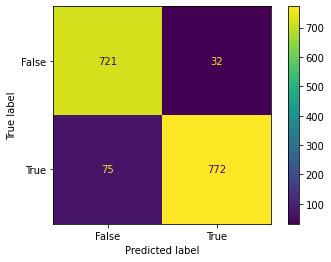

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=model.classes_)
disp.plot(values_format='')

#### Interpreting the Confusion Matrix
In a binary classification problem (as it is the case in this application scenario), one can interpret the plot as follows:
- Top-right: Number of cases where they actually not have a true label and the true label was predicted. So it is (**FP**) **F**alse that it is true (**P**ositive). In our case, we must minimize this!
- Bottom-left: Number of cases where they actually have a true label and the true label was not predicted. So it is (**FN**) **F**alse that it is false (**N**egative). In our case, we maybe can minimize this.
- Top-left: Number of cases where they actually not have a true label and the true label was not predicted. So it is (**TN**) **T**rue that it is false (**N**egative).
- Bottom-right: Number of cases where they actually have the true label and the true label was predicted. So it is (**TP**) **T**rue that it is true (**P**ositive).

## 10. PMML Export
Finally, the trained model can now be exported with the library [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) to PMML.

> If necessary, the `sklearn2pmml` must be organised in advance via pip. Since `sklearn2pmml` requires the JRE (Java Runtime Environment), JRE may have to be installed beforehand, depending on the Jupyter environment.


In [ ]:
try:
    import sklearn2pmml
except ImportError as e:
    !pip -q install sklearn2pmml
from sklearn2pmml import _java_version
java_version = _java_version("UTF-8")
if java_version is None:
    !sudo apt -qq update
    !sudo apt -qq install -y default-jre
    java_version = _java_version("UTF-8")

print(java_version)

Afterwards, a pipeline can be initialised and a PMML file can be written.

In [ ]:
from sklearn2pmml import make_pmml_pipeline, sklearn2pmml

pipeline = make_pmml_pipeline(
    model,
    active_fields= ["category", "urgency", "targetPrice", "price"],
    target_fields= ["approved"]
)
sklearn2pmml(pipeline, "order-approval-sklearn.pmml")

## 11. PMML Deployment and Testing
After we have created the PMML file, we can upload it to the Camunda Platform with the Camunda Modeler as shown in Fig 11a.

![](https://github.com/DigiBP/digibp-camunda-classroom/raw/master/modelling/pmml/order-approval-camunda-pmml-deploy.png)\
**Fig 11a**: deployment of models and other files (e.g., PMML files) with the Camunda Modeler

In a next step, we can investigate the `deployment-id` of the deployments within the Camunda Platform Cockpit. For executing the PMML files together with a Camunda Workflow, we can use the provided classroom instantiation. The classroom instantiation has been extended with `jpmml`, the [Java PMML API](https://github.com/jpmml), and provides now an own basic testing Swagger UI. This [PMML API Swagger UI](https://digibp.herokuapp.com/swagger-ui/#/pmmlapi) gives us the possibility, to `generate-input` fields and `evluate` our PMML model as depicted in Fig 11b.

![](https://github.com/DigiBP/digibp-camunda-classroom/raw/master/modelling/pmml/camunda-pmml-api.png)\
**Fig 11b**: PMML API Swagger UI

## 12. Decision Task and PMML Connector
With the configuration insights from the PMML API using the [PMML API Swagger UI](https://digibp.herokuapp.com/swagger-ui/#/pmmlapi), one can now configure the decision task within the BPMN model by using the Camunda Modeler. The classroom instantiation has been extended with a specific Camunda Connector for PMML, which can be used to execute a PMML model, provide input data from workflow variables and pass on output data (predictions) to workflow variables. Fig 12a shows the configurations required on the `order-approval-sklearn-init.bpmn` ([download BPMN model - here](https://ghcdn.rawgit.org/DigiBP/digibp-camunda-classroom/master/modelling/pmml/order-approval-sklearn-init.bpmn)) process.

![](https://raw.githubusercontent.com/DigiBP/digibp-camunda-classroom/master/modelling/pmml/order-approval-camunda-pmml.png)\
**Fig 12a**: PMML-connector configuration in Camunda Modeler